# Distributed Full-Field Inference

This notebook demonstrates Bayesian inference of cosmological parameters from full-field convergence maps.

We use a half-sky configuration (observer at (0.5, 0.5, 1.0)) and perform distributed sampling using BlackJAX MCLMC to infer cosmological parameters from synthetic observations.

## Imports

In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
os.environ["EQX_ON_ERROR"] = "nan"
os.environ["JAX_ENABLE_X64"] = "False"

import jax

jax.config.update("jax_enable_x64", False)

import time
from pathlib import Path

import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
from diffrax import RecursiveCheckpointAdjoint
from jaxpm.distributed import normal_field
from numpyro.handlers import condition, seed, trace
from scipy.stats import norm

from fwd_model_tools import Configurations, Planck18, full_field_probmodel, reconstruct_full_kappa
from fwd_model_tools.lensing_model import compute_box_size_from_redshift
from fwd_model_tools.plotting import plot_ic, plot_kappa, plot_lightcone, plot_posterior
from fwd_model_tools.sampling import batched_sampling, load_samples

print(f"JAX devices: {jax.device_count()}")
print(f"JAX backend: {jax.default_backend()}")

JAX devices: 1
JAX backend: gpu


## Configuration Parameters

In [2]:
output_dir = "output_02_distributed"
box_shape = (256 , 256 , 256)
max_redshift = 0.5
number_of_shells = 9
geometry = "spherical"
observer_position = (0.5, 0.5, 1.0)
num_warmup = 20
num_samples = 20
batch_count = 50
sampler = "MCLMC"
backend = "blackjax"
sigma_e = 0.3
magick_seed = 42

output_dir_path = Path(output_dir)
plots_dir = output_dir_path / "plots"
samples_dir = output_dir_path / "samples"
data_dir = output_dir_path / "data"

plots_dir.mkdir(parents=True, exist_ok=True)
samples_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

fiducial_cosmology = Planck18()
box_size = compute_box_size_from_redshift(fiducial_cosmology, max_redshift, observer_position)

print(f"Box size: {box_size} Mpc/h")
print(f"Max redshift: {max_redshift}")
print(f"Observer position (half-sky): {observer_position}")

Box size: (2635.3309394476964, 2635.3309394476964, 1317.6654697238482) Mpc/h
Max redshift: 0.5
Observer position (half-sky): (0.5, 0.5, 1.0)


## Setup Sharding and Redshift Distribution

In [3]:
if jax.device_count() > 1:
    from jax.sharding import NamedSharding
    from jax.sharding import PartitionSpec as P

    mesh = jax.make_mesh((4, 2), ("x", "y"))
    sharding = NamedSharding(mesh, P("x", "y"))
    print(f"Using sharding with mesh: (4, 2)")
else:
    sharding = None
    print("Single device mode - no sharding")

z = jnp.linspace(0, max_redshift, 1000)
z_centers = jnp.linspace(0.2, max_redshift - 0.01, 4)
z_centers = jnp.round(z_centers, 3)
print(f"z_centers = {z_centers}")

nz_shear = [
    jc.redshift.kde_nz(
        z,
        norm.pdf(z, loc=z_center, scale=0.12),
        bw=0.01,
        zmax=max_redshift,
        gals_per_arcmin2=g,
    )
    for z_center, g in zip(z_centers, [7, 8.5, 7.5, 7])
]
nbins = len(nz_shear)

Single device mode - no sharding
z_centers = [0.2   0.297 0.393 0.49 ]


## Instantiate Probabilistic Model

In [4]:
config = Configurations(
    field_size=9.6,
    field_npix=box_shape[0],
    box_shape=box_shape,
    box_size=box_size,
    number_of_shells=number_of_shells,
    density_plane_npix=box_shape[0],
    nside=box_shape[0],
    density_plane_smoothing=0.1,
    nz_shear=nz_shear,
    fiducial_cosmology=Planck18,
    sigma_e=sigma_e,
    priors={
        "Omega_c": dist.Uniform(0.20, 0.30),
        "sigma8": dist.Uniform(0.7, 0.9),
    },
    t0=0.1,
    dt0=0.1,
    t1=1.0,
    min_redshift=0.01,
    max_redshift=max_redshift,
    sharding=sharding,
    halo_size=0 if sharding is None else box_shape[0] // 8,
    adjoint=RecursiveCheckpointAdjoint(4),
    geometry=geometry,
    observer_position=observer_position,
    log_lightcone=True,
    log_ic=True,
)

print("Configuration created")

initial_conditions = normal_field(jax.random.key(magick_seed), config.box_shape, sharding=sharding)
print("Initial conditions generated")

Configuration created
Initial conditions generated


## Trace Model to Generate Synthetic Observations

In [5]:
print("Generating synthetic observations")

full_field_basemodel = full_field_probmodel(config)

fiducial_model = condition(
    full_field_basemodel,
    {
        "Omega_c": fiducial_cosmology.Omega_c,
        "sigma8": fiducial_cosmology.sigma8,
        "initial_conditions": initial_conditions,
    },
)

print("Tracing fiducial model to generate observables...")
start_time = time.time()
model_trace = trace(seed(fiducial_model, 0)).get_trace()
elapsed = time.time() - start_time
print(f"Fiducial model traced in {elapsed:.2f}s")

kappa_keys = [f"kappa_{i}" for i in range(nbins)]
true_kappas_visible = {key: model_trace[key]["value"] for key in kappa_keys}

if config.geometry == "spherical":
    true_kappas_full = reconstruct_full_kappa(
        true_kappas_visible, config.nside, config.observer_position
    )
else:
    true_kappas_full = true_kappas_visible

np.savez(
    data_dir / "true_kappas.npz",
    **true_kappas_visible,
    Omega_c=fiducial_cosmology.Omega_c,
    sigma8=fiducial_cosmology.sigma8,
)

true_ic = np.asarray(model_trace["ic"]["value"])
np.save(data_dir / "true_ic.npy", true_ic)

true_lightcone = np.asarray(model_trace["lightcone"]["value"])
np.save(data_dir / "true_lightcone.npy", true_lightcone)

print("Saved observations to disk")

Generating synthetic observations


Tracing fiducial model to generate observables...


/lustre/fswork/projects/rech/tkc/commun/venv/nbody/lib/python3.11/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion=standard. In future JAX releases this will result in an error.
  warnings.warn(


Fiducial model traced in 12.24s
Saved observations to disk


## Plot Lightcone

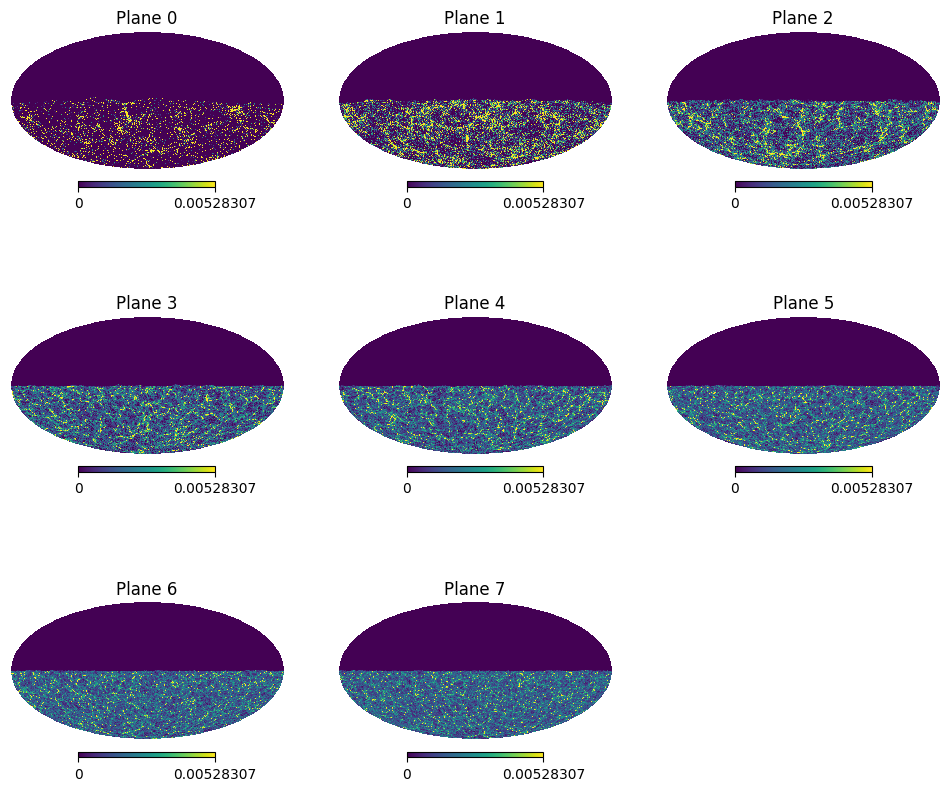

Plotted lightcone


In [6]:
plot_lightcone(true_lightcone, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print("Plotted lightcone")

## Plot Kappa Maps

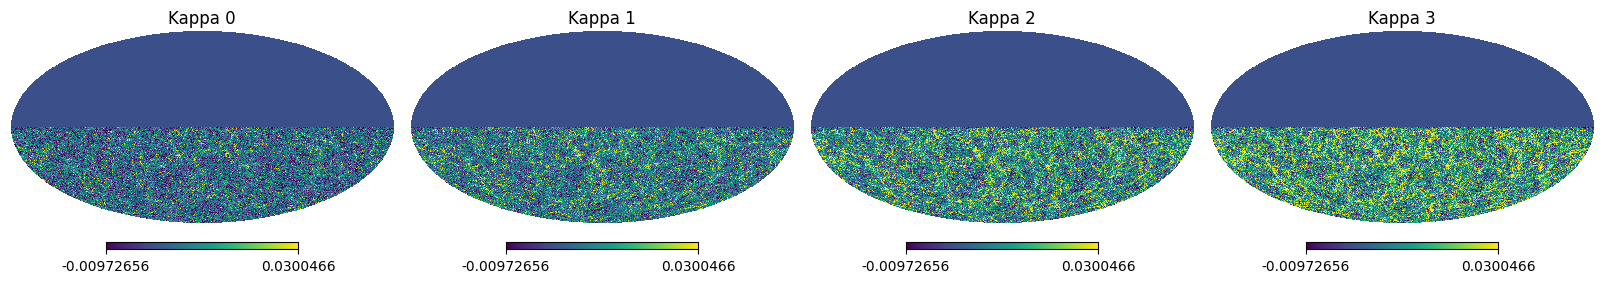

Plotted kappa maps


In [7]:
kappa_array = np.stack([true_kappas_full[k] for k in kappa_keys])
plot_kappa(kappa_array, plots_dir, spherical=(geometry == "spherical"), output_format="show")
print("Plotted kappa maps")

## Condition Model on Observations

In [8]:
print("Setting up MCMC inference")

config_inference = config._replace(log_lightcone=False, log_ic=True)
full_field_basemodel = full_field_probmodel(config_inference)

observed_model = condition(
    full_field_basemodel,
    {f"kappa_{i}": true_kappas_visible[f"kappa_{i}"] for i in range(nbins)},
)

init_params = {
    "Omega_c": fiducial_cosmology.Omega_c,
    "sigma8": fiducial_cosmology.sigma8,
    "initial_conditions": initial_conditions,
}
init_params = jax.tree.map(jnp.asarray, init_params)

print(f"Sampling with {sampler} using {backend} backend")
print(f"Warmup: {num_warmup}, Samples: {num_samples}, Batches: {batch_count}")

Setting up MCMC inference
Sampling with MCLMC using blackjax backend
Warmup: 20, Samples: 20, Batches: 50


## Run Distributed Inference

In [ ]:
batched_sampling(
    model=observed_model,
    path=str(samples_dir),
    rng_key=jax.random.PRNGKey(magick_seed),
    num_warmup=num_warmup,
    num_samples=num_samples,
    batch_count=batch_count,
    sampler=sampler,
    backend=backend,
    save=True,
    init_params=init_params,
    progress_bar=True,
)

print("MCMC sampling completed")

‚ñ∂Ô∏è Resuming for MCLMC using blackjax...


/lustre/fswork/projects/rech/tkc/commun/venv/nbody/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


üì¶ Sampling batch 26/50 using MCLMC with blackjax...

at sample batch 26, total samples: 500




üíæ Saving batch 26 samples and state...
üì¶ Sampling batch 27/50 using MCLMC with blackjax...

at sample batch 27, total samples: 520




üíæ Saving batch 27 samples and state...
üì¶ Sampling batch 28/50 using MCLMC with blackjax...

at sample batch 28, total samples: 540


## Load Samples and Analyze Results

In [9]:
print("Loading samples and analyzing results")

scalar_samples = load_samples(str(samples_dir), param_names=["Omega_c", "sigma8"])
print(f"Loaded {len(scalar_samples['Omega_c'])} samples")
print(f"Parameters: {list(scalar_samples.keys())}")

true_data = np.load(data_dir / "true_kappas.npz")
true_Omega_c = float(true_data["Omega_c"])
true_sigma8 = float(true_data["sigma8"])

print("\nPosterior Statistics:")
print(f"True Omega_c: {true_Omega_c:.4f}")
print(f"Inferred Omega_c: {scalar_samples['Omega_c'].mean():.4f} ¬± {scalar_samples['Omega_c'].std():.4f}")
print(f"True sigma8: {true_sigma8:.4f}")
print(f"Inferred sigma8: {scalar_samples['sigma8'].mean():.4f} ¬± {scalar_samples['sigma8'].std():.4f}")

Loading samples and analyzing results
Loading 34 sample batch(es) from output_02_distributed/samples
  Loading batch 1/34: samples_0


/lustre/fswork/projects/rech/tkc/commun/venv/nbody/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


  Loading batch 2/34: samples_1
  Loading batch 3/34: samples_10
  Loading batch 4/34: samples_11
  Loading batch 5/34: samples_12
  Loading batch 6/34: samples_13
  Loading batch 7/34: samples_14
  Loading batch 8/34: samples_15
  Loading batch 9/34: samples_16
  Loading batch 10/34: samples_17
  Loading batch 11/34: samples_18
  Loading batch 12/34: samples_19
  Loading batch 13/34: samples_2
  Loading batch 14/34: samples_20
  Loading batch 15/34: samples_21
  Loading batch 16/34: samples_22
  Loading batch 17/34: samples_23
  Loading batch 18/34: samples_24
  Loading batch 19/34: samples_25
  Loading batch 20/34: samples_26
  Loading batch 21/34: samples_27
  Loading batch 22/34: samples_28
  Loading batch 23/34: samples_29
  Loading batch 24/34: samples_3
  Loading batch 25/34: samples_30
  Loading batch 26/34: samples_31
  Loading batch 27/34: samples_32
  Loading batch 28/34: samples_33
  Loading batch 29/34: samples_4
  Loading batch 30/34: samples_5
  Loading batch 31/34: samp

## Plot Initial Conditions Comparison

In [16]:
print("Loading IC field statistics...")
ic_mean, ic_std = load_samples(str(samples_dir), param_names=["ic"], transform=("mean", "std"))

Loading IC field statistics...
Loading 34 sample batch(es) from output_02_distributed/samples
  Loading batch 1/34: samples_0


/lustre/fswork/projects/rech/tkc/commun/venv/nbody/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


  Loading batch 2/34: samples_1
  Loading batch 3/34: samples_10
  Loading batch 4/34: samples_11
  Loading batch 5/34: samples_12
  Loading batch 6/34: samples_13
  Loading batch 7/34: samples_14
  Loading batch 8/34: samples_15
  Loading batch 9/34: samples_16
  Loading batch 10/34: samples_17
  Loading batch 11/34: samples_18
  Loading batch 12/34: samples_19
  Loading batch 13/34: samples_2
  Loading batch 14/34: samples_20
  Loading batch 15/34: samples_21
  Loading batch 16/34: samples_22
  Loading batch 17/34: samples_23
  Loading batch 18/34: samples_24
  Loading batch 19/34: samples_25
  Loading batch 20/34: samples_26
  Loading batch 21/34: samples_27
  Loading batch 22/34: samples_28
  Loading batch 23/34: samples_29
  Loading batch 24/34: samples_3
  Loading batch 25/34: samples_30
  Loading batch 26/34: samples_31
  Loading batch 27/34: samples_32
  Loading batch 28/34: samples_33
  Loading batch 29/34: samples_4
  Loading batch 30/34: samples_5
  Loading batch 31/34: samp

In [35]:
font_size = 16
plt.rcParams.update(
    {
        "font.size": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        "axes.titlesize": font_size,
        "font.family": "serif",
        "legend.frameon": True,
    }
)

In [ ]:
if "ic" in ic_mean:
    true_ic = np.load(data_dir / "true_ic.npy")
    plot_ic(
        true_ic,
        ic_mean["ic"],
        ic_std["ic"],
        plots_dir,
        titles=("True IC", "Mean IC", "Std IC", "Diff IC"),
        output_format="pdf",
    )
    print("Plotted IC comparison")

Plotted IC comparison


## Plot Posterior (GetDist 3-panel)

Removed no burn in


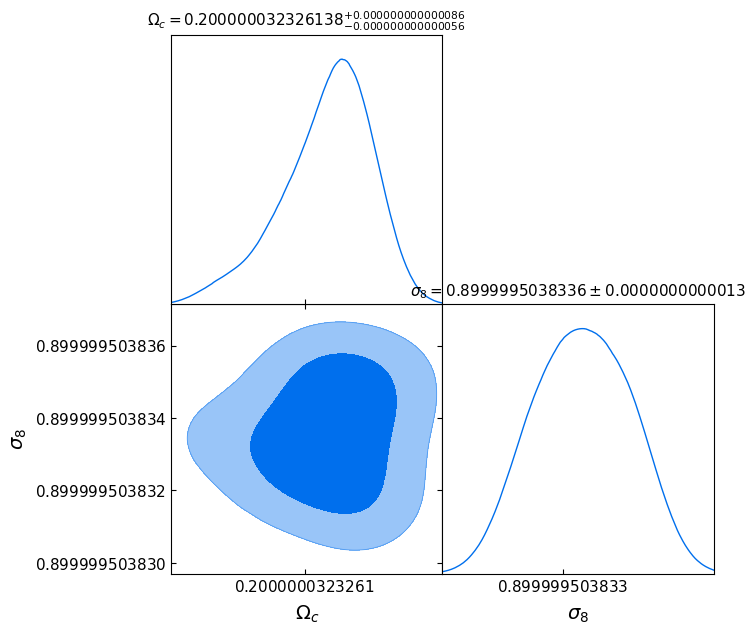

Plotted posteriors


In [ ]:
param_samples = {"Omega_c": scalar_samples["Omega_c"], "sigma8": scalar_samples["sigma8"]}
true_param_values = {"Omega_c": true_Omega_c, "sigma8": true_sigma8}


labels = {"Omega_c": r"\Omega_c", "sigma8": r"\sigma_8"}

plot_posterior(
    param_samples,
    plots_dir,
    params=("Omega_c", "sigma8"),
    true_values=true_param_values,
    labels=labels,
    output_format="show",
    filled=True,
    title_limit=1,
    width_inch=7,
)
print("Plotted posteriors")